
# Genetikus algoritmusok – Egyedábrázolások és operátorok (v2, HU)

**V2 újdonságok:**
- Bináris fixpontos kódolás \[-5,5\] + adaptív mutációs ráta
- Valós kódolás: BLX-α crossover + sigma-adaptív Gauss mutáció
- Permutáció: PMX, OX és inverziós mutáció
- Fa: típusos részfa-csere, mélységkorlát
- Gráf: összefüggőség megőrzése, bővített fenotípus-statisztikák


## 0) Telepítés (Colab esetén)

In [ ]:

# Szükséges csomagok
!pip -q install sympy networkx


In [ ]:

# Importok és alapbeállítások
import math
import random
from typing import List, Tuple, Optional
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import sympy as sp
from sympy import symbols
from sympy.parsing.sympy_parser import parse_expr

np.set_printoptions(precision=4, suppress=True)
random.seed(42)
np.random.seed(42)



## 1) Genotípus vs. Fenotípus – magyarázat és rövid példa

- Genotípus: az a forma, amelyen az evolúciós operátorok dolgoznak (pl. bitlánc).
- Fenotípus: a genotípus kiértelmezése a problémában (pl. számérték, költség).
- A leképezés legyen egyértelmű és determinista.


In [ ]:

def binary_to_decimal(bits: List[int]) -> int:
    return int("".join(map(str, bits)), 2)

# Példa
bit_g = [1,1,0,1]
print("Genotípus (bináris):", bit_g)
print("Fenotípus (decimális):", binary_to_decimal(bit_g))


Genotípus (bináris): [1, 1, 0, 1]
Fenotípus (decimális): 13



## 2) Bináris kódolás (fixpontos dekódolás) + adaptív mutáció


In [ ]:

def adaptive_mutation_rate(gen: int, max_gen: int, p_start: float=0.2, p_end: float=0.01) -> float:
    # Exponenciálisan csökkenő mutációs ráta
    t = gen / max_gen
    return p_end * (p_start / p_end) ** (1 - t)

def binary_mutation(bits: List[int], p: float) -> List[int]:
    return [1-b if random.random() < p else b for b in bits]

def binary_one_point_crossover(p1: List[int], p2: List[int]) -> List[int]:
    assert len(p1) == len(p2)
    point = random.randint(1, len(p1)-1)
    return p1[:point] + p2[point:]

def decode_fixed_point(bits: List[int], low: float=-5.0, high: float=5.0) -> float:
    # Bináris fixpontos dekódolás a [low, high] intervallumra
    val = binary_to_decimal(bits)
    max_val = (1 << len(bits)) - 1
    return low + (high - low) * val / max_val

# Demonstráció
n_bits = 10
parent1 = [random.randint(0,1) for _ in range(n_bits)]
parent2 = [random.randint(0,1) for _ in range(n_bits)]
child = binary_one_point_crossover(parent1, parent2)

p_mut = adaptive_mutation_rate(gen=10, max_gen=100)
mut_child = binary_mutation(child, p=p_mut)

print("Szülő1:", parent1)
print("Szülő2:", parent2)
print("Utód  :", child)
print("Mutált utód:", mut_child)
print("Fenotípus (valós, [-5,5]):", decode_fixed_point(mut_child))
print("Alkalmazott adaptív mutációs ráta:", p_mut)


Szülő1: [0, 0, 1, 0, 0, 0, 0, 0, 1, 0]
Szülő2: [0, 0, 0, 0, 0, 0, 1, 0, 1, 1]
Utód  : [0, 0, 0, 0, 0, 0, 1, 0, 1, 1]
Mutált utód: [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
Fenotípus (valós, [-5,5]): -4.970674486803519
Alkalmazott adaptív mutációs ráta: 0.14822688982138954


### Mutációs ráta alakulása (ábra)

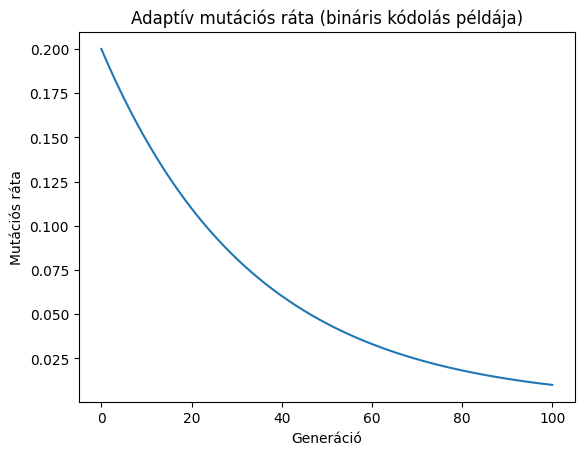

In [ ]:

gens = np.arange(0, 101)
rates = [adaptive_mutation_rate(g, 100) for g in gens]

plt.figure()
plt.plot(gens, rates)
plt.xlabel("Generáció")
plt.ylabel("Mutációs ráta")
plt.title("Adaptív mutációs ráta (bináris kódolás példája)")
plt.show()



## 3) Valós értékű kódolás – BLX-α crossover + sigma-adaptív mutáció


In [ ]:

def blx_alpha_crossover(p1: np.ndarray, p2: np.ndarray, alpha: float=0.3) -> np.ndarray:
    low = np.minimum(p1, p2)
    high = np.maximum(p1, p2)
    d = high - low
    a = low - alpha * d
    b = high + alpha * d
    return np.random.uniform(a, b)

def sigma_adaptive_mutation(x: np.ndarray, gen: int, max_gen: int, sigma_start: float=0.5, sigma_end: float=0.05, bounds: Tuple[float,float]=(-5,5)) -> np.ndarray:
    t = gen / max_gen
    sigma = sigma_end * (sigma_start / sigma_end) ** (1 - t)
    y = x + np.random.normal(0, sigma, size=len(x))
    return np.clip(y, bounds[0], bounds[1])

# Demonstráció
p1 = np.array([1.0, -2.0, 3.0])
p2 = np.array([2.0, -1.0, 2.5])
child = blx_alpha_crossover(p1, p2, alpha=0.5)
mut_child = sigma_adaptive_mutation(child, gen=30, max_gen=100)

print("Szülő1:", p1)
print("Szülő2:", p2)
print("BLX-α utód:", child)
print("Sigma-adaptív mutált utód:", mut_child)
print("Fenotípus (példa, Σx^2):", float(np.sum(mut_child**2)))


Szülő1: [ 1. -2.  3.]
Szülő2: [ 2.  -1.   2.5]
BLX-α utód: [ 1.2491 -0.5986  2.982 ]
Sigma-adaptív mutált utód: [ 0.9705 -0.5187  3.0519]
Fenotípus (példa, Σx^2): 10.524993276211958



## 4) Permutációs kódolás – PMX, OX és inverziós mutáció


In [ ]:

def pmx_crossover(p1: List[int], p2: List[int]) -> List[int]:
    n = len(p1)
    a, b = sorted(random.sample(range(n), 2))
    child = [None]*n
    child[a:b] = p1[a:b]
    mapping = {p2[i]: p1[i] for i in range(a, b)}
    for i in list(range(0, a)) + list(range(b, n)):
        candidate = p2[i]
        while candidate in mapping:
            candidate = mapping[candidate]
        child[i] = candidate
    return child

def ox_crossover(p1: List[int], p2: List[int]) -> List[int]:
    n = len(p1)
    a, b = sorted(random.sample(range(n), 2))
    child = [None]*n
    child[a:b] = p1[a:b]
    fill = [x for x in p2 if x not in child[a:b]]
    idxs = list(range(b, n)) + list(range(0, a))
    for i, v in zip(idxs, fill):
        child[i] = v
    return child

def inversion_mutation(p: List[int]) -> List[int]:
    n = len(p)
    a, b = sorted(random.sample(range(n), 2))
    return p[:a] + list(reversed(p[a:b])) + p[b:]

# Demonstráció
p1 = [1,2,3,4,5,6,7,8,9]
p2 = [9,8,7,6,5,4,3,2,1]

print("PMX:", pmx_crossover(p1, p2))
print("OX :", ox_crossover(p1, p2))
print("Inv:", inversion_mutation(p1))


PMX: [1, 2, 3, 4, 5, 4, 3, 2, 1]
OX : [1, 2, 3, 4, 5, 6, 7, 9, 8]
Inv: [1, 6, 5, 4, 3, 2, 7, 8, 9]


### Fenotípus-értékelés TSP-stílusú példával

In [ ]:

# Példa költségmátrix
C = np.array([
    [0, 2, 9, 10, 7, 6, 4, 8, 3],
    [2, 0, 6, 4, 3, 5, 8, 2, 7],
    [9, 6, 0, 8, 5, 7, 3, 4, 6],
    [10, 4, 8, 0, 1, 2, 9, 3, 5],
    [7, 3, 5, 1, 0, 4, 6, 2, 3],
    [6, 5, 7, 2, 4, 0, 5, 6, 4],
    [4, 8, 3, 9, 6, 5, 0, 4, 2],
    [8, 2, 4, 3, 2, 6, 4, 0, 5],
    [3, 7, 6, 5, 3, 4, 2, 5, 0],
])

def tour_cost(perm: List[int], C: np.ndarray) -> float:
    cost = 0.0
    for i in range(len(perm)):
        a = perm[i]-1
        b = perm[(i+1) % len(perm)]-1
        cost += C[a, b]
    return cost

child_pmx = pmx_crossover(p1, p2)
child_ox = ox_crossover(p1, p2)
mut_inv = inversion_mutation(child_pmx)

print("Költség PMX utód:", tour_cost(child_pmx, C))
print("Költség OX utód :", tour_cost(child_ox, C))
print("Költség Inv(mut):", tour_cost(mut_inv, C))


Költség PMX utód: 42.0
Költség OX utód : 43.0
Költség Inv(mut): 42.0



## 5) Fa-struktúrás kódolás – típusos részfa-csere és mélységkorlát


In [ ]:

x, y, z = symbols('x y z')

OPS = [sp.Add, sp.Mul]
TERMS = [x, y, z]

def random_const():
    return sp.Integer(random.randint(-3, 3))

def random_terminal():
    return random.choice(TERMS + [random_const()])

def random_expr(depth=2):
    if depth <= 0:
        return random_terminal()
    op = random.choice(OPS)
    return op(random_expr(depth-1), random_expr(depth-1))

def node_type_tag(e):
    if isinstance(e, sp.Symbol): return "var"
    if isinstance(e, sp.Integer): return "const"
    if isinstance(e, sp.Add): return "Add"
    if isinstance(e, sp.Mul): return "Mul"
    return "other"

def preorder_nodes(expr):
    return list(sp.preorder_traversal(expr))

def replace_subtree(expr, target, replacement):
    return expr.xreplace({target: replacement})

def typed_subtree_crossover(e1, e2):
    n1 = preorder_nodes(e1)
    n2 = preorder_nodes(e2)
    random.shuffle(n1)
    for sub1 in n1:
        tag = node_type_tag(sub1)
        candidates = [s for s in n2 if node_type_tag(s) == tag]
        if candidates:
            sub2 = random.choice(candidates)
            return replace_subtree(e1, sub1, sub2), replace_subtree(e2, sub2, sub1)
    s1 = random.choice(n1)
    s2 = random.choice(preorder_nodes(e2))
    return replace_subtree(e1, s1, s2), replace_subtree(e2, s2, s1)

def depth_limited_random_expr(max_depth=3):
    d = random.randint(0, max_depth)
    return random_expr(depth=d)

# Demonstráció
e1 = parse_expr("(x + y) * z")
e2 = parse_expr("x * (y + z)")

c1, c2 = typed_subtree_crossover(e1, e2)
m1 = replace_subtree(c1, random.choice(preorder_nodes(c1)), depth_limited_random_expr(2))

point = {x:1, y:2, z:3}
print("Szülő1:", e1)
print("Szülő2:", e2)
print("Utód1 :", c1, " -> érték:", c1.subs(point))
print("Utód2 :", c2, " -> érték:", c2.subs(point))
print("Mutált:", m1, " -> érték:", m1.subs(point))


Szülő1: z*(x + y)
Szülő2: x*(y + z)
Utód1 : 2*x*z  -> érték: 6
Utód2 : y*(y + z)  -> érték: 10
Mutált: 2*x*z**2  -> érték: 18



## 6) Gráf/szabályhalmaz-alapú kódolás – összefüggőség megőrzése


G1 stat: {'avg_degree': 1.6, 'density': 0.17777777777777778, 'components': 2, 'connected': False, 'diameter': None}
G2 stat: {'avg_degree': 1.8, 'density': 0.2, 'components': 2, 'connected': False, 'diameter': None}
Utód stat: {'avg_degree': 3.2, 'density': 0.35555555555555557, 'components': 1, 'connected': True, 'diameter': 4}
Utód (összefüggő) stat: {'avg_degree': 3.2, 'density': 0.35555555555555557, 'components': 1, 'connected': True, 'diameter': 4}


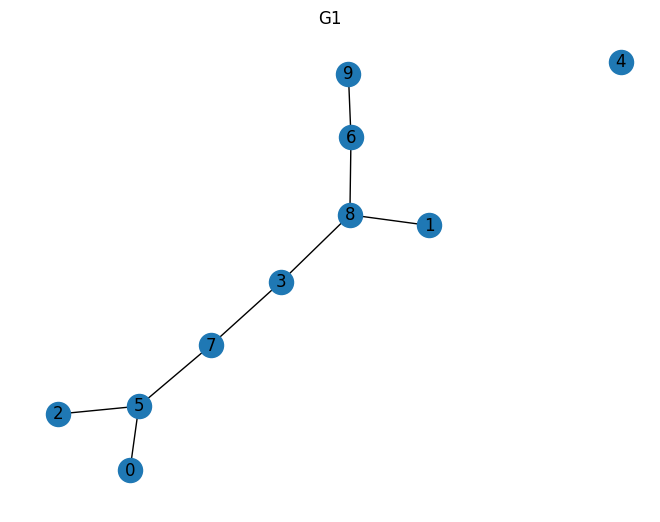

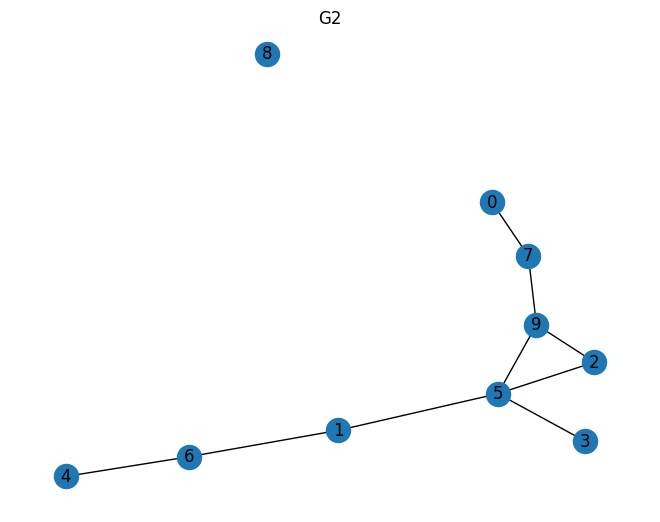

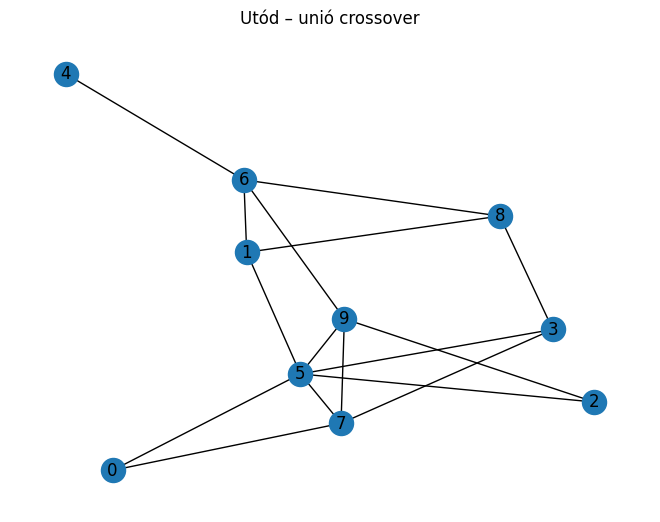

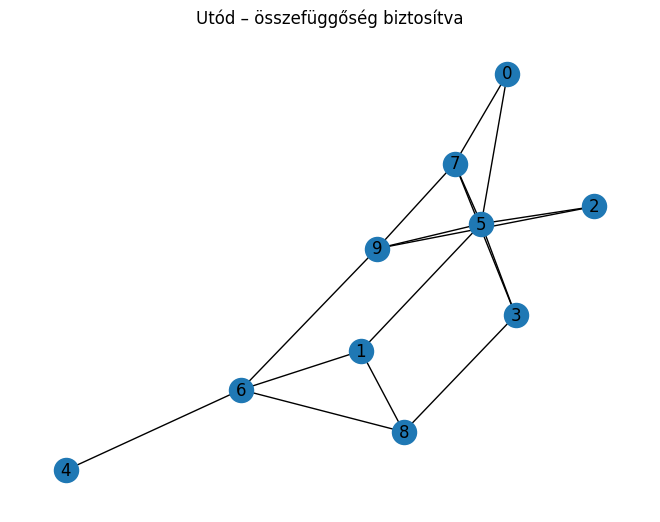

In [ ]:

def random_graph(n=8, p=0.25):
    G = nx.Graph()
    G.add_nodes_from(range(n))
    for i in range(n):
        for j in range(i+1, n):
            if random.random() < p:
                G.add_edge(i, j)
    return G

def graph_union_crossover(G1: nx.Graph, G2: nx.Graph) -> nx.Graph:
    H = nx.Graph()
    H.add_nodes_from(G1.nodes())
    H.add_edges_from(G1.edges())
    H.add_edges_from(G2.edges())
    return H

def ensure_connected(G: nx.Graph) -> nx.Graph:
    H = G.copy()
    comps = list(nx.connected_components(H))
    if len(comps) <= 1:
        return H
    comps = [list(c) for c in comps]
    for i in range(len(comps)-1):
        H.add_edge(comps[i][0], comps[i+1][0])
    return H

def graph_stats(G: nx.Graph):
    degrees = [d for _, d in G.degree()]
    density = nx.density(G)
    comps = nx.number_connected_components(G)
    connected = comps == 1
    diameter = nx.diameter(G) if connected and G.number_of_nodes() > 1 else None
    return {
        "avg_degree": float(np.mean(degrees)) if degrees else 0.0,
        "density": density,
        "components": comps,
        "connected": connected,
        "diameter": diameter
    }

# Demonstráció
G1 = random_graph(10, 0.2)
G2 = random_graph(10, 0.2)
child = graph_union_crossover(G1, G2)
child_conn = ensure_connected(child)

print("G1 stat:", graph_stats(G1))
print("G2 stat:", graph_stats(G2))
print("Utód stat:", graph_stats(child))
print("Utód (összefüggő) stat:", graph_stats(child_conn))

# Vizualizációk
plt.figure()
nx.draw(G1, with_labels=True)
plt.title("G1")
plt.show()

plt.figure()
nx.draw(G2, with_labels=True)
plt.title("G2")
plt.show()

plt.figure()
nx.draw(child, with_labels=True)
plt.title("Utód – unió crossover")
plt.show()

plt.figure()
nx.draw(child_conn, with_labels=True)
plt.title("Utód – összefüggőség biztosítva")
plt.show()



## 7) Összehasonlító táblázat – ábrázolási formák

| Ábrázolás | Előny | Hátrány | Tipikus feladat | Operátorok |
|---|---|---|---|---|
| Bináris | Egyszerű, robusztus | Folytonos tartományra kvantálás kell | Diszkrét paraméter, logikai maszk | Bit-flip, 1/2-pontos crossover |
| Valós | Folytonos optimalizálás | Korlátok kezelése | Numerikus hangolás | Gauss-mutáció, BLX-α/aritmetikai |
| Permutáció | Sorrend/útvonal megőrzés | Operátorok bonyolultabbak | TSP, ütemezés | PMX, OX, inverziós mutáció |
| Fa | Nagy kifejező erő | Bloat, stabilitás | Szimbolikus regresszió, GP | Részfa-csere, részfa-mutáció |
| Gráf | Topológiák, hálók | Nehéz érvényesség | Hálózattervezés, biohálók | Él-műveletek, részgráf-csere |



## 8) Kérdések – rövid válaszok

- Mi a különbség a genotípus és a fenotípus között?  
  Genotípus: kódolt forma; Fenotípus: értelmezett megoldás/viselkedés.

- Sorolj fel legalább három egyedábrázolási formát!  
  Bináris, valós, permutáció (továbbá: fa, gráf).

- Miért előnyös a bináris kódolás? Mik a hátrányai?  
  Előny: egyszerű, robusztus; Hátrány: folytonos terekre kvantálás, felbontási korlátok.

- Milyen problémákra alkalmas a permutációs kódolás?  
  Útvonal- és sorrend-optimalizálás (TSP, ütemezés, logisztika).

- Hogyan hat az ábrázolás megválasztása a genetikai operátorok működésére?  
  Az operátorokat az ábrázoláshoz kell illeszteni (pl. permutációnál duplikációmentesítés, fáknál típusos részfa-csere, gráfnál összefüggőség karbantartása).
